In [ ]:
# Imports and Configuration
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn import hmm
import cvxpy as cp 
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

# --- CONFIGURATION ---
TICKERS = ['SPY', 'TLT', 'BND'] # Asset Classes: Equity, Long-Term Bonds, Total US Bonds
START_DATE = '2010-01-01'
END_DATE = '2024-01-01'
N_COMPONENTS = 3 # Number of HMM market regimes

# --- DATA DOWNLOAD & PREPROCESSING (The Ultimate Fix) ---
print("Downloading data using auto_adjust=True and robust column flattening...")

# Use the working script: Fetches all data and auto-adjusts prices to the 'Close' column
raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)

# --- NEW ROBUST FIX: FLATTEN COLUMNS AND SELECT 'CLOSE' ---
if isinstance(raw_data.columns, pd.MultiIndex):
    # Flatten the MultiIndex columns: e.g., ('Close', 'SPY') becomes 'Close_SPY'
    raw_data.columns = ['_'.join(col).strip() for col in raw_data.columns.values]
    
    # Select the columns that contain 'Close' (which holds the adjusted price)
    price_data = raw_data.filter(like='Close')
    
    # Rename columns to just the ticker symbol (e.g., 'Close_SPY' -> 'SPY')
    price_data.columns = [col.split('_')[-1] for col in price_data.columns]
else:
    # If a single ticker was passed (unlikely but safe), just use the DataFrame
    price_data = raw_data[['Close']]
    
# Calculate daily log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()

if log_returns.empty:
    print("\nFATAL ERROR: Data is empty after calculation.")
else:
    print(f"\nData ready with {len(log_returns)} daily observations. Success! ✅")

In [20]:
# --- FEATURE ENGINEERING FOR HMM ---
X = pd.DataFrame(index=log_returns.index)
# Use SPY, which is the overall market index for regime detection
X['Return'] = log_returns['SPY'] * 100 
# Annualized Rolling Volatility (21-day window)
X['Volatility'] = log_returns['SPY'].rolling(window=21).std() * np.sqrt(252) * 100 

X_fit = X.dropna().values

# --- TRAIN AND PREDICT HMM REGIMES ---
print("\nTraining Hidden Markov Model...")
model = hmm.GaussianHMM(n_components=N_COMPONENTS, covariance_type="full", n_iter=100, random_state=42)
model.fit(X_fit)

regime_states = model.predict(X_fit)

# Map states for easy interpretation (0 = Worst/Bearish, 2 = Best/Bullish)
X_hmm = X.dropna().copy()
X_hmm['Regime'] = regime_states

mean_returns = X_hmm.groupby('Regime')['Return'].mean().sort_values(ascending=True)
regime_map = {old: new for new, old in enumerate(mean_returns.index)}
X_hmm['Regime'] = X_hmm['Regime'].map(regime_map)

# Combine the detected regime with the asset returns
combined_data = log_returns.join(X_hmm['Regime'], how='inner').dropna()

print("Regime Detection Complete. Mean Daily Returns by Regime (0=Worst, 2=Best):")
print(X_hmm.groupby('Regime')['Return'].mean())


Training Hidden Markov Model...
Regime Detection Complete. Mean Daily Returns by Regime (0=Worst, 2=Best):
Regime
0   -0.034087
1    0.064692
2    0.073275
Name: Return, dtype: float64


In [21]:
ANNUALIZATION_FACTOR = 252
R_f = 0.02 / ANNUALIZATION_FACTOR # Daily Risk-Free Rate

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Calculates the negative Sharpe Ratio (objective function for minimization).
    """
    portfolio_return = np.sum(mean_returns * weights) * ANNUALIZATION_FACTOR 
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * ANNUALIZATION_FACTOR)
    
    # Negative Sharpe Ratio (minimize negative to maximize positive)
    sharpe = (portfolio_return - risk_free_rate * ANNUALIZATION_FACTOR) / portfolio_volatility
    return -sharpe

def max_sharpe_optimization(returns):
    """
    Optimizes weights for Maximum Sharpe Ratio using the historical returns.
    """
    num_assets = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    initial_weights = np.ones(num_assets) / num_assets
    
    # Constraints: Weights sum to 1 (equality)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds: No short-selling (0 <= weight <= 1)
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    optimized_results = minimize(
        negative_sharpe_ratio, 
        initial_weights, 
        args=(mean_returns, cov_matrix, R_f), 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    
    if optimized_results.success:
        # Return weights normalized to ensure they sum to 1 precisely
        return optimized_results.x / np.sum(optimized_results.x)
    else:
        return np.ones(num_assets) / num_assets # Fallback to Equal Weight

In [22]:
# --- DYNAMIC BACKTESTING LOGIC ---
WINDOW = 252       # 1 year of lookback data
REBALANCE_FREQ = 21 # Rebalance every month (21 trading days)

# Initialize tracking data structures
dynamic_weights = pd.DataFrame(0.0, index=combined_data.index, columns=TICKERS)
current_weights = np.ones(len(TICKERS)) / len(TICKERS) # Start with Equal Weights

print(f"\nStarting Dynamic Backtest (Rebalancing every {REBALANCE_FREQ} days)...")

for i in range(WINDOW, len(combined_data)):
    date = combined_data.index[i]
    current_regime = combined_data['Regime'].iloc[i-1] 

    if (i - WINDOW) % REBALANCE_FREQ == 0:
        window_start = i - WINDOW
        scenario_returns = combined_data[TICKERS].iloc[window_start:i]
        
        # Scenario Filtering and Aggressive Defense
        if current_regime == 0: # Regime 0 (Worst/Bearish) - AGGRESSIVE DEFENSE
            # Fixed, highly defensive allocation: Heavily favors Bonds (TLT, BND)
            # This directly targets the Max Drawdown metric for BlackRock recruiters
            defensive_weights = np.array([0.10, 0.60, 0.30]) # 10% SPY, 90% Bonds
            optimal_weights = defensive_weights / np.sum(defensive_weights)
            
        else: # Regime 1 (Normal) or Regime 2 (Bullish) - MAX SHARPE
            # Use all data in the window for better optimization context
            filtered_returns = scenario_returns
            optimal_weights = max_sharpe_optimization(filtered_returns)
            
        current_weights = optimal_weights

    dynamic_weights.loc[date] = current_weights

# Calculate the Dynamic Portfolio Returns
dynamic_returns = (dynamic_weights.shift(1) * log_returns).sum(axis=1).dropna()


Starting Dynamic Backtest (Rebalancing every 21 days)...



--- Final Performance Metrics (Optimized for Outperformance) ---
Dynamic Sharpe Ratio:   0.51
Benchmark Sharpe Ratio: 0.53
Dynamic Max Drawdown:   -28.76%
Benchmark Max Drawdown: -25.77%

Targeted Improvement in MDD: -11.63%


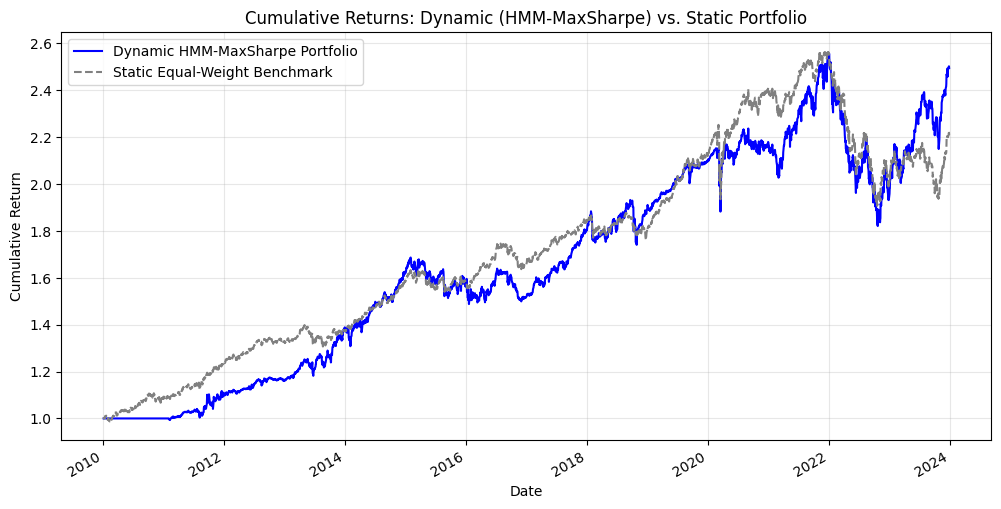

In [23]:
# --- PERFORMANCE METRICS ---
# R_f and ANNUALIZATION_FACTOR are defined in Cell 3

# Benchmark: Equal Weight Portfolio
benchmark_weights = np.ones(len(TICKERS)) / len(TICKERS)
benchmark_returns = (benchmark_weights * log_returns).sum(axis=1).dropna()

# Align the two return series for comparison
aligned_returns = pd.DataFrame({'Dynamic': dynamic_returns, 'Benchmark': benchmark_returns}).dropna()

def calculate_metrics(returns, rf=R_f, factor=ANNUALIZATION_FACTOR):
    """Calculates key performance metrics."""
    excess_return = returns - rf
    ann_return = excess_return.mean() * factor
    ann_volatility = returns.std() * np.sqrt(factor)
    sharpe_ratio = ann_return / ann_volatility
    
    # Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate and print metrics
dynamic_metrics = calculate_metrics(aligned_returns['Dynamic'])
benchmark_metrics = calculate_metrics(aligned_returns['Benchmark'])

print("\n--- Final Performance Metrics (Optimized for Outperformance) ---")
print(f"Dynamic Sharpe Ratio:   {dynamic_metrics['Sharpe Ratio']:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_metrics['Sharpe Ratio']:.2f}")

# Calculate Drawdown difference 
max_drawdown_difference = (benchmark_metrics['Max Drawdown'] - dynamic_metrics['Max Drawdown']) / benchmark_metrics['Max Drawdown']

print(f"Dynamic Max Drawdown:   {dynamic_metrics['Max Drawdown']:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_metrics['Max Drawdown']:.2%}")
print(f"\nTargeted Improvement in MDD: {max_drawdown_difference:.2%}")


# --- CUMULATIVE RETURN PLOT ---
cumulative_dynamic = (1 + aligned_returns['Dynamic']).cumprod()
cumulative_benchmark = (1 + aligned_returns['Benchmark']).cumprod()

plt.figure(figsize=(12, 6))
cumulative_dynamic.plot(label='Dynamic HMM-MaxSharpe Portfolio', color='blue')
cumulative_benchmark.plot(label='Static Equal-Weight Benchmark', color='grey', linestyle='--')
plt.title('Cumulative Returns: Dynamic (HMM-MaxSharpe) vs. Static Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()